# BBC News Classification

## Imports

In [1]:
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline

from sklearn.decomposition import NMF
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

%matplotlib inline

## Exploratory Data Analysis (EDA)

Let's load the data. The data was copied from [Kaggle: BBC News Classification Competition](https://www.kaggle.com/competitions/learn-ai-bbc/)

In [2]:
train_csv = os.path.join('./data', 'BBC News Train.csv')
test_csv = os.path.join('./data', 'BBC News Test.csv')

In [3]:
test_df = pd.read_csv(train_csv)
df = pd.read_csv(train_csv)

In [4]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
df.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

It looks like the text is pre-processed. All the words are converted to lowercase. No NAs. 
One issue is the Category is text. We need a numeric value for ML algorithms. 
Let's create a mapping of string categories to numeric values and add the relevant columns to both train and test datasets

In [6]:
category_str_to_id = {i[1]:i[0] for i in enumerate(df['Category'].factorize()[1])}
df['category_id'] = df['Category'].apply(lambda x: category_str_to_id[x])
df.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [7]:
test_df['category_id'] = test_df['Category'].apply(lambda x: category_str_to_id[x])
test_df.head()

,ArticleId,Text,Category,category_id
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


An important factor to consider is whether the dataset is balanced. An imbalanced dataset may require additional processing, such as resampling with oversampling of minor and undersampling of major classes.  

<Axes: xlabel='Category'>

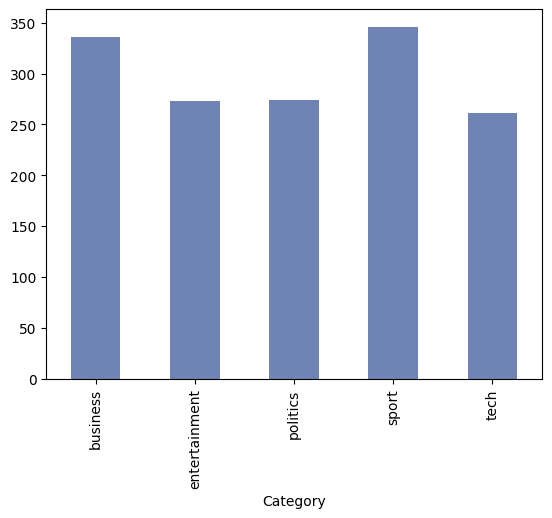

In [8]:
df.groupby('Category')['category_id'].count().plot(kind='bar', color='#6F84B4')

There are no issues here. The dataset is nicely balanced.

## Non-Negative Matrix Factorization (NMF) model

Any unsupervised algorithms, including NMF, don't know anything about expected output. 
To classify texts by category using NMF we assume that category is a latent factor. 
The problem is that even though NMF will help to find these latent factors, it won't associate the latent factor with the target variable. 
To do this association we will create a post-NMF transormer. 

In [9]:
class PostNmfTransformer:
    def __init__(self):
        self.latent_to_y = None
        
    def fit(self, X, y=None):
        latent = X.argmax(axis=1)
        df = pd.DataFrame(dict(y=y, yh=latent))
        self.latent_to_y = dict(df.groupby('yh')['y'].value_counts().groupby(level=0).idxmax().tolist())
        
    def transform(self, X):
        latent = X.argmax(axis=1)
        return np.array([self.latent_to_y[l] for l in latent])
        
    def score(self, X, y):
        yh = self.transform(X)
        return accuracy_score(y, yh)

Another thing is that we need to vectorize the texts. We will use two steps for it.
1. Bag of words. The sklearn CountVectorizer transformer will count the n-grams in the text.
   CountVectorizer converts text documents into a matrix of token counts. Each row represents a document, each column represents a term. The values show how many times each term appears in each document
N-grams:
Unigrams (n=1): Single words (e.g., "cat", "sat")
Bigrams (n=2): Two consecutive words (e.g., "the cat", "sat on")
Trigrams (n=3): Three consecutive words (e.g., "the cat sat")
2. TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document within a larger collection of documents (corpus). The Term Frequency (TF) part measures how frequently a term occurs in a document, while the Inverse Document Frequency (IDF) part decreases the weight of terms that occur very frequently across many documents (like "the" or "is") and increases the weight of terms that occur rarely. By multiplying TF and IDF together, we get a composite weight that is high when a term occurs frequently in a specific document but rarely in the overall corpus, making TF-IDF particularly useful for tasks like document classification, information retrieval, and text mining. A common example is that in a document about cats, the word "cat" might appear many times (high TF), but since it's not common across all documents (high IDF), it would get a high TF-IDF score, indicating it's an important word for that specific document.

   We will choose just arbitrary hyperparameters and check the results

In [10]:
clf = Pipeline([('vect', CountVectorizer(encoding='latin-1', 
                                         ngram_range=(1, 2), 
                                         stop_words='english')),
                ('tfidf', TfidfTransformer(sublinear_tf=True, 
                                           norm='l2')),
                ('nmf', NMF(n_components=5, random_state=42)),
                ('post', PostNmfTransformer())])

In [11]:
clf.fit(df['Text'], df['category_id'])

Pipeline(steps=[('vect',
                 CountVectorizer(encoding='latin-1', ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('nmf', NMF(n_components=5, random_state=42)),
                ('post', <__main__.PostNmfTransformer object at 0x157e3a0e0>)])

In [12]:
res = clf.transform(df.Text)

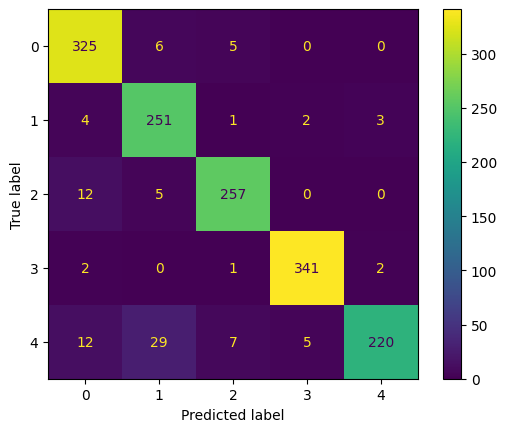

In [13]:
cm = confusion_matrix(df['category_id'], res)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The confusion matrix looks quite nice. 

Let's try to finetune the model by searching among the hyperparameters

In [14]:
cv_params = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__min_df': [2, 4, 8],
    'tfidf__norm': ('l1', 'l2'),
}

In [15]:
gs_clf = GridSearchCV(clf, cv_params, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(df['Text'], df['category_id'])
gs_clf.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(encoding='latin-1', min_df=4,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer(norm='l1', sublinear_tf=True)),
                ('nmf', NMF(n_components=5, random_state=42)),
                ('post', <__main__.PostNmfTransformer object at 0x16c9bb250>)])

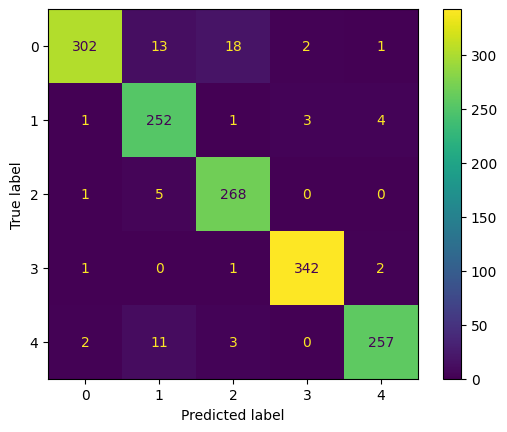

In [16]:
res = gs_clf.best_estimator_.transform(df['Text'])
cm = confusion_matrix(df['category_id'], res)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

The confusion matrix looks better than the one with arbitrary parameters.
Let's check accuracy on a train and test data

In [17]:
print(f"The best model accuracy (train): {gs_clf.best_score_.round(2)}")

The best model accuracy (train): 0.95


In [18]:
print(f"The best model accuracy (test): {round(gs_clf.score(test_df['Text'], test_df['category_id']), 2)}")

The best model accuracy (test): 0.95


## Compare NMF with Linear Classifiers with Stochastic Gradient Descend

SGDClassifier incorporates linear classifiers (SVM, logistic regression, etc.) with SGD training.
In the case the loss is 'hinge', the classifier is SVM. If the loss is 'log_loss', it is logistic regression.
Let's start from the SVM, and then optimize hyperparameters including the loss function.

In [19]:
svm_clf = Pipeline([('vect', CountVectorizer(min_df=4, 
                                          encoding='latin-1', 
                                          ngram_range=(1, 2), 
                                          stop_words='english')),
                    ('tfidf', TfidfTransformer(sublinear_tf=True, 
                                           norm='l2')),
                    ('clf', SGDClassifier(loss='log_loss', penalty='l2',
                                          random_state=42,
                                          max_iter=5, tol=None))])

In [20]:
svm_clf.fit(df['Text'], df['category_id'])

Pipeline(steps=[('vect',
                 CountVectorizer(encoding='latin-1', min_df=4,
                                 ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf',
                 SGDClassifier(loss='log_loss', max_iter=5, random_state=42,
                               tol=None))])

In [21]:
svm_res = svm_clf.predict(df['Text'])

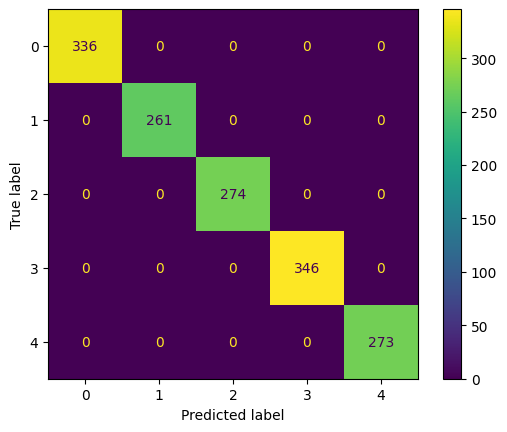

In [22]:
cm = confusion_matrix(df['category_id'], svm_res)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

Not bad. Looks like the accuracy is 100%!!! 

In [23]:
print(f"The best model accuracy (test): {svm_clf.score(test_df['Text'], test_df['category_id'])}")

The best model accuracy (test): 1.0


And it doesn't overfit! Just regular Logistic Regression gives outstanding performance.
I don't know if there is a reason to perform a grid search having such results but let's try

In [24]:
svn_cv_params = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__min_df': [2, 4, 8],
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (1e-2, 1e-3),
    'clf__loss': ('hinge', 'log_loss')
}

In [25]:
gs_clf = GridSearchCV(svm_clf, svn_cv_params, cv=5, scoring='accuracy', n_jobs=-1)
gs_clf = gs_clf.fit(df['Text'], df['category_id'])
gs_clf.best_estimator_

Pipeline(steps=[('vect',
                 CountVectorizer(encoding='latin-1', min_df=2,
                                 ngram_range=(1, 3), stop_words='english')),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [26]:
print(f"The best model accuracy (train): {gs_clf.best_score_.round(2)}")

The best model accuracy (train): 0.98


In [27]:
print(f"The best model accuracy (test): {round(gs_clf.score(test_df['Text'], test_df['category_id']), 2)}")

The best model accuracy (test): 1.0


The grid search gives worse results than the arbitrary hyperparameter selection. It has chosen SVM, not Logistic Regression. 

Anyhow, comparing the best NMF accuracy of 0.95 with close to 1.0 accuracy for both SVM and Logistic Regression, I can conclude that the abovementioned supervised learning models are better suited for text classification tasks.

## Conclusion

The comparative analysis between Non-negative Matrix Factorization (NMF), Support Vector Machines (SVM), and Logistic Regression revealed that both SVM and Logistic Regression demonstrated superior performance for text classification tasks. 

While NMF is valuable for topic modeling and document clustering through its ability to decompose text data into interpretable features, its performance as a classifier fell short compared to the discriminative power of SVM and Logistic Regression. 

The strong performance of both SVM and Logistic Regression in text classification can be attributed to their ability to effectively handle high-dimensional sparse data typical in text analysis, where documents are represented as term frequency or TF-IDF vectors. It correlates with the suggestion that discriminative models (like SVM) are particularly well-suited for text classification problems, where the goal is to learn explicit boundaries between document categories rather than modeling the underlying topic structure of the texts.

Let's not neglect the power of NMF for the unsupervised cases when the target variable is not known or semi-supervised cases when the trained data is partially classified. Here NMF would thrive. 

## Resources

1. [Kaggle: BBC News Classification Competition](https://www.kaggle.com/competitions/learn-ai-bbc/)
2. [Problem-solving with ML: automatic document classification](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification)
3. [Wikipedia: tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
4. [Wikipedia: bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)